In [1]:
import polars as pl # pandas alternative
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
from google.colab import drive

%matplotlib inline

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
df = pl.read_csv("../dataset/gex_bg.csv")
df.head(2)

,Groups,KIF2C,CKAP2L,CLSPN,RRM2,KIF15,RAD51AP1,PDE2A,ESPL1,TOP2A,SCN4B,DONSON,CAV1,ADAM33,CA4,CCNF,RTKN2,ESR1,CALCOCO1,DSCC1,ADAMTS14,MOCS1,CDC123,MCM6,IGFBP6,SH2B2,PFDN2,CDKN2D,SH2D2A,TGFBR2,YIF1B,DNAJC9,GABRD,LSM4,MTHFD2,GPD1L,CPA1,DLX5,AKAP12
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""TCGA-BH-A0DO-1…","""True Normal""",5.921534,4.483925,4.729687,7.372847,5.503581,6.84533,10.903429,7.104192,8.957781,11.666671,8.030993,14.393112,10.208477,8.326867,8.38698,5.71163,14.028197,13.042089,7.77199,3.793489,11.38389,10.792756,11.223094,11.552438,5.408571,9.532778,7.428025,6.191874,14.257346,9.653267,8.794281,2.021772,11.007834,10.264198,13.520508,5.549639,4.069984,11.92032
"""TCGA-BH-A1FC-1…","""True Normal""",5.266557,3.793489,4.999592,6.39451,5.071419,6.148151,12.299547,5.170503,7.409333,10.562531,8.158863,15.727832,11.084216,9.949333,8.27539,6.214829,13.227042,12.73864,7.181301,3.684176,10.740383,11.080304,10.919016,11.867226,7.372847,9.934001,7.68844,6.805619,15.108937,10.088811,7.913651,4.014537,11.376526,11.211936,12.66083,5.503581,5.217004,13.042089


# Expression of DONSON in Breast cancer


The function of this gene is unknown according to NCBI.

UniPROT database based on the only one paper "Mutations in DONSON disrupt replication fork stability and cause microcephalic dwarfism" tells us that DONSON is involved in replisome component that maintains genome stability by protecting stalled or damaged replication forks. After the induction of replication stress, required for the stabilization of stalled replication forks, the efficient activation of the intra-S-phase and G/2M cell-cycle checkpoints and the maintenance of genome stability.

As genome instability is one of the hallmarks of cancer. Also upregulation of DONSON can be explained by Cell proliferation hallmark to support cancer cells growth ensuring its DNA replication. Thus we hypotesize that DONSON gene expression levels in average will be upregulated in breast cancers.


In [4]:
gene_sym = "DONSON"
gene_df = df.select(pl.col("Groups", gene_sym))
gene_df = gene_df.with_columns(
    [
        pl.col("Groups").cast(pl.Categorical),
        pl.when(pl.col("Groups") == "True Normal")
        .then("True normal")
        .otherwise("Breast cancer")
        .alias("Category"),
    ]
)

## Descriptive statistics and data visualisations


Data visualisations to compare True normal group with different breast cances subtypes as well as comparisons between True normal and united cancer group.


In [5]:
group_by_healthy = gene_df.groupby(by="Category").agg(
    min=pl.min(gene_sym),
    max=pl.max(gene_sym),
    std=pl.std(gene_sym),
    mean=pl.mean(gene_sym),
    median=pl.median(gene_sym),
    q1=pl.quantile(gene_sym, 0.25),
    q3=pl.quantile(gene_sym, 0.75),
    counts=pl.count(),
)
group_by_healthy

Category,min,max,std,mean,median,q1,q3,counts
str,f64,f64,f64,f64,f64,f64,f64,u32
"""True normal""",7.499656,9.594321,0.491902,8.297881,8.17175,8.017075,8.578171,46
"""Breast cancer""",7.639277,12.361295,0.831187,9.621046,9.560611,8.973923,10.142124,946


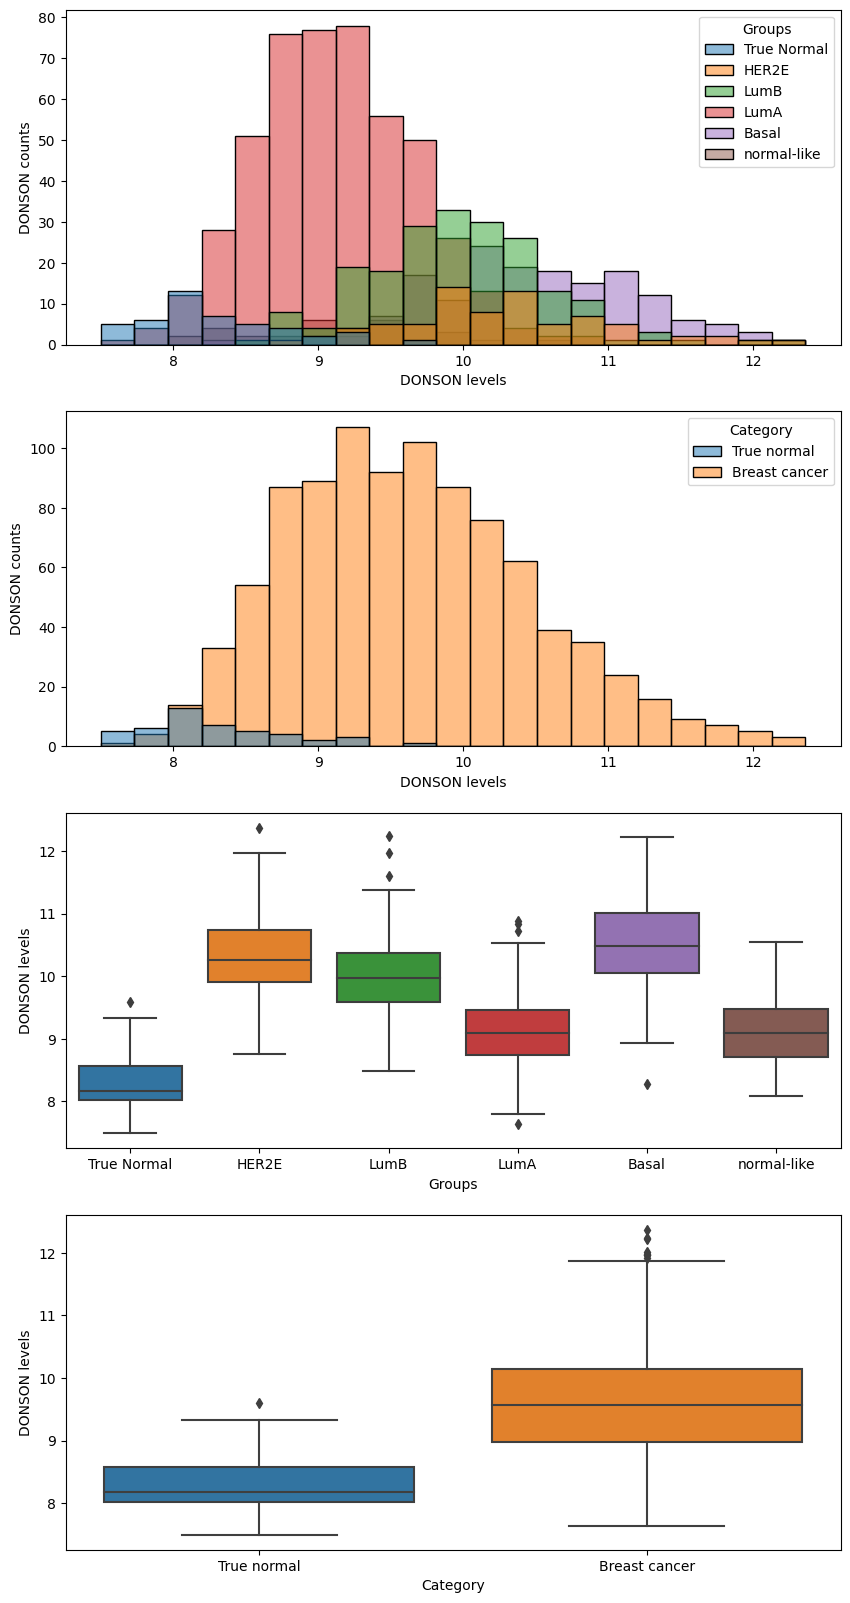

In [6]:
gene_data = gene_df.to_pandas()
fig, ax = plt.subplots(4, 1, figsize=(10, 20))
sns.histplot(x=gene_sym, hue="Groups", data=gene_data, ax=ax[0])
sns.histplot(x=gene_sym, hue="Category", data=gene_data, ax=ax[1])
sns.boxplot(x="Groups", y=gene_sym, data=gene_data, ax=ax[2])
sns.boxplot(x="Category", y=gene_sym, data=gene_data, ax=ax[3])
ax[0].set_ylabel(f"{gene_sym} counts")
ax[0].set_xlabel(f"{gene_sym} levels")
ax[1].set_ylabel(f"{gene_sym} counts")
ax[1].set_xlabel(f"{gene_sym} levels")
ax[2].set_ylabel(f"{gene_sym} levels")
ax[3].set_ylabel(f"{gene_sym} levels")
plt.show()

According to these plots we can assume that central tendencies among True normal and Breast cancer groups are different.

To prove these visualisations in terms of difference in average levels of DONSON expression in True normal and Breast cancer groups we need to perform statistical tests. As we have two independent samples we can rely on t-test for independent samples.

But first we need to check t-test assumptions: normality of distribution will be checked by Shapiro-Wilk test, equality of variances across groups - by Levene's test.


## Normality test - Shapiro-Wilk Test

H<sub>0</sub>: DONSON expression levels in True normal and cancer groups are normally distributed.

H<sub>1</sub>: DONSON expression levels in True normal and cancer groups are not normally distributed.


In [7]:
data = {
    "normal": gene_df.filter(pl.col("Category") == "True normal").select(
        pl.col(gene_sym)
    ),
    "cancer": gene_df.filter(pl.col("Category") == "Breast cancer").select(
        pl.col(gene_sym)
    ),
}
print(stats.shapiro(data["normal"]))
print(stats.shapiro(data["cancer"]))

ShapiroResult(statistic=0.9410641193389893, pvalue=0.021450428292155266)
ShapiroResult(statistic=0.9837163686752319, pvalue=9.004747170138216e-09)


Results interpretation: p-values for both True normal and Breast cancer groups are less than 0.05 thus we can reject null hypothesis - distribution of both groups is not normal. However, since the group sizes are large (946 for cancer group and 46 for healthy group), we can use t-test.


## Equality of variance test - Leven's test

H<sub>0</sub>: Variances in expression levels of DONSON are equal in both True normal and Breast cancer groups.

H<sub>1</sub>: Variances in expression levels of DONSON are not equal in both True normal and Breast cancer groups.


In [9]:
print(
    stats.levene(
        data["normal"].to_numpy().flatten(), data["cancer"].to_numpy().flatten()
    )
)

LeveneResult(statistic=16.461088772203937, pvalue=5.356688778571687e-05)


Results interpretation: p-value is below 0.05 so we can reject null hypothesis and assume variances to be different in True normal and Breast cancer groups. Thus we can use Welch's t-test to check equality of means among groups.


## Equality of means test - Welch's t-test

H<sub>0</sub>: Average DONSON expression levels in True normal and Breast cancer groups are equal.

H<sub>1</sub>: Average DONSON expression levels in True normal and Breast cancer groups are not equal.


In [10]:
t_results = stats.ttest_ind(data["normal"], data["cancer"], equal_var=False)
print(t_results)

TtestResult(statistic=array([-17.09555853]), pvalue=array([2.20210667e-24]), df=array([58.30926334]))


Results interpretation: low p-value indicates that means of DONSON expression levels in True normal and Breast cancer groups are not equal thus we can reject t-test null hypothesis.


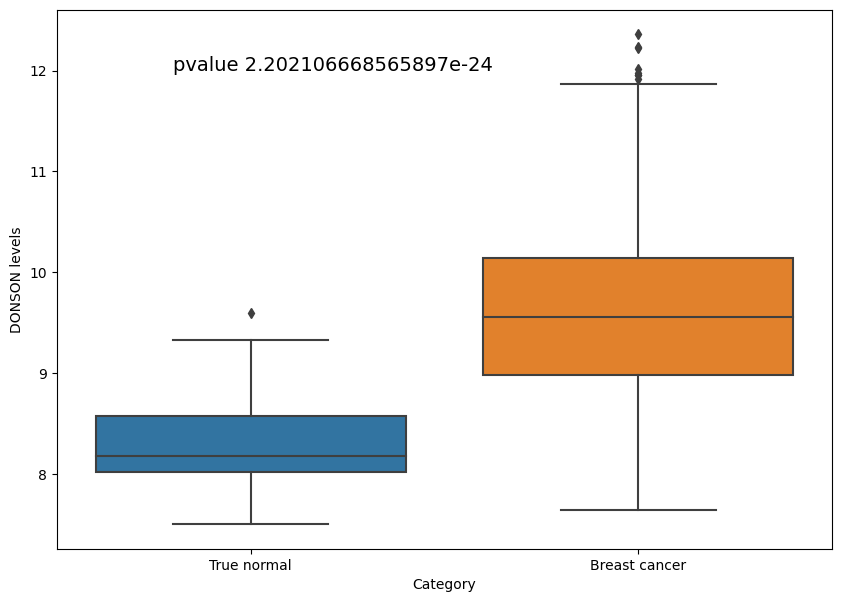

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(x="Category", y=gene_sym, data=gene_data, ax=ax)
ax.set_ylabel(f"{gene_sym} levels")
plt.text(-0.2, 12, f"pvalue {t_results.pvalue[0]}", fontsize=14)
plt.show()

# Expression of DONSON in Breast cancer molecular subtypes


**Luminal A**: Typically hormone receptor-positive (estrogen and/or progesterone receptors), HER2-negative, and has the best prognosis among all subtypes.

**Luminal B**: Hormone receptor-positive, may be HER2-positive or HER2-negative, generally has a higher grade and worse prognosis than Luminal A.

**HER2-enriched**: HER2-positive and hormone receptor-negative, more aggressive, but potentially responsive to targeted HER2 therapies.

**Triple-negative/Basal-like**: Lacks estrogen, progesterone, and HER2 receptors, often more aggressive, younger onset, and fewer targeted treatment options.

Here we analyse DONSON gene expression in different molecular subtypes of breast cancer.


In [12]:
group_by_subtype = gene_df.groupby(by="Groups").agg(
    min=pl.min(gene_sym),
    max=pl.max(gene_sym),
    std=pl.std(gene_sym),
    mean=pl.mean(gene_sym),
    median=pl.median(gene_sym),
    q1=pl.quantile(gene_sym, 0.25),
    q3=pl.quantile(gene_sym, 0.75),
    counts=pl.count(),
)
group_by_subtype

Groups,min,max,std,mean,median,q1,q3,counts
cat,f64,f64,f64,f64,f64,f64,f64,u32
"""True Normal""",7.499656,9.594321,0.491902,8.297881,8.17175,8.017075,8.578171,46
"""HER2E""",8.757067,12.361295,0.689738,10.320565,10.266291,9.902676,10.744698,74
"""LumB""",8.491776,12.238878,0.608749,9.963244,9.964857,9.582288,10.363585,199
"""LumA""",7.639277,10.87944,0.533629,9.108869,9.089483,8.738532,9.477255,480
"""Basal""",8.27539,12.225417,0.696901,10.504653,10.481213,10.049793,11.015581,161
"""normal-like""",8.089335,10.546093,0.602498,9.11238,9.088545,8.728997,9.483443,32


There are 6 groups of data, so we will use one-way ANOVA to test if the mean DONSON expression is different among groups.

We can visualise cancer subtypes as interval plot.


In [21]:
confidence = 0.95

# counting standard error of the mean
group_with_ci = group_by_subtype.select(
    pl.col(["Groups", "std", "counts", "mean"])
).with_columns((pl.col("std") / pl.col("counts").sqrt()).alias("sem"))

# calculating intervals using stats.t.interval
group_with_ci = group_with_ci.with_columns(
    pl.struct([pl.col("counts"), pl.col("mean"), pl.col("sem")]).alias("intervals")
)
group_with_ci = group_with_ci.with_columns(
    pl.col("intervals").apply(
        lambda x: stats.t.interval(
            confidence, x["counts"] - 1, loc=x["mean"], scale=x["sem"]
        )
    )
)

group_with_ci

Groups,std,counts,mean,sem,intervals
cat,f64,u32,f64,f64,object
"""True Normal""",0.491902,46,8.297881,0.072527,"(8.15180364653598, 8.44395761114937)"
"""HER2E""",0.689738,74,10.320565,0.08018,"(10.160765124804204, 10.48036388826511)"
"""LumB""",0.608749,199,9.963244,0.043153,"(9.878144998500693, 10.048342268298098)"
"""LumA""",0.533629,480,9.108869,0.024357,"(9.061009984731067, 9.156728498326801)"
"""Basal""",0.696901,161,10.504653,0.054923,"(10.396184098935459, 10.613120941941292)"
"""normal-like""",0.602498,32,9.11238,0.106508,"(8.895156816403578, 9.329603964365294)"


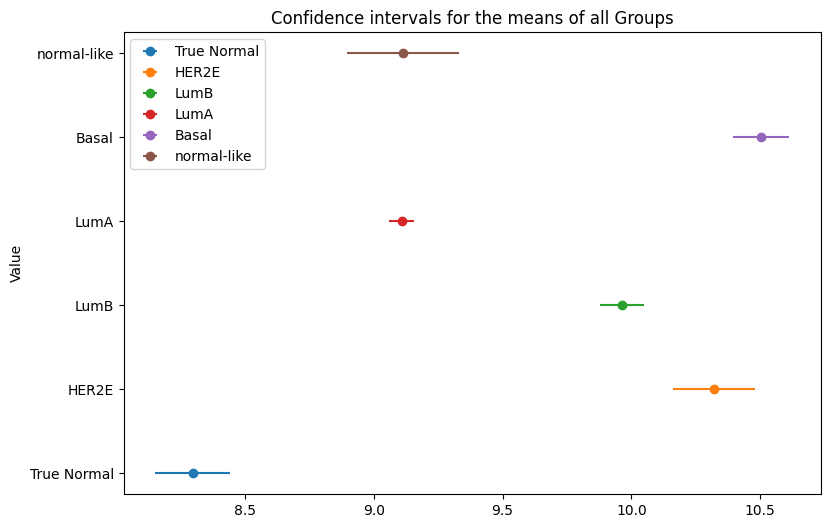

In [31]:
plt.figure(figsize=(9, 6))
for idx, row in enumerate(group_with_ci.rows(named=True)):
    plt.errorbar(
        y=row["Groups"],
        x=row["mean"],
        xerr=(row["intervals"][1] - row["mean"]),
        fmt="o",
        label=row["Groups"],
    )
    plt.ylabel("Value")
plt.title("Confidence intervals for the means of all Groups")
plt.legend()
plt.show()

Now we need to check ANOVA assumptions of homogenity of variances.


## Equality of variance test - Leven's test

H<sub>0</sub>: Variances in expression levels of DONSON are equal among all groups.

H<sub>1</sub>: Variances in expression levels of DONSON are not equal among all groups.


In [26]:
unique_subtypes = gene_df["Groups"].unique().to_list()
unique_subtypes_data = []
for subtype in unique_subtypes:
    unique_subtypes_data.append(
        gene_df.filter(pl.col("Groups") == subtype)
        .select(pl.col(gene_sym))
        .to_numpy()
        .flatten()
    )
print(stats.levene(*unique_subtypes_data))

LeveneResult(statistic=4.698033816058603, pvalue=0.00030237351935006684)


Results interpretation: p-value is below 0.05 so we can reject null hypothesis and assume variances are not equal among groups. Although ANOVA assumption is violated we still can proceed as we have large samples.


## ANOVA

H<sub>0</sub>: There is no difference among group means.

H<sub>1</sub>: Means are not all equal.


In [27]:
model = smf.ols(f"{gene_sym} ~ Groups", data=gene_data).fit()
anova_test = pl.DataFrame(sm.stats.anova_lm(model))
anova_test

df,sum_sq,mean_sq,F,PR(>F)
f64,f64,f64,f64,f64
5.0,396.211825,79.242365,226.898553,3.6221e-161
986.0,344.352007,0.349241,null,null


Results interpretation: as p-value is below 0.05 we can reject our null hypothesis thus we can conclude that at least one group mean differs from others.

As equality of variances assumption was violated we can support our ANOVA results with non-parametric Kruskal-Wallis test.


## Kruskal-Wallis H-test for independent samples

H<sub>0</sub>: Medians are equal

H<sub>1</sub>: Medians are not equal.


In [28]:
stats.kruskal(*unique_subtypes_data)

KruskalResult(statistic=539.4452193913356, pvalue=2.432830075532835e-114)

Results interpretation: as p-value is below 0.05 we can reject our null hypothesis thus we can conclude that at least one group median differs from others. This results support our ANOVA results.

Now we can apply TukeyHSD test for pairwise comparison of groups to find out which group means are statistically different.


## Tukey HSD test

H<sub>0</sub>: The means of the groups are equal.

H<sub>1</sub>: The means of the groups are **not** equal.


In [29]:
tukey_test = pairwise_tukeyhsd(gene_data[gene_sym], gene_data["Groups"])
tukey_test.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Basal,HER2E,-0.1841,0.2303,-0.4211,0.0529,False
Basal,LumA,-1.3958,0.0,-1.5495,-1.2421,True
Basal,LumB,-0.5414,0.0,-0.7203,-0.3625,True
Basal,True Normal,-2.2068,0.0,-2.4889,-1.9247,True
Basal,normal-like,-1.3923,0.0,-1.7189,-1.0657,True
HER2E,LumA,-1.2117,0.0,-1.4224,-1.001,True
HER2E,LumB,-0.3573,0.0001,-0.5871,-0.1276,True
HER2E,True Normal,-2.0227,0.0,-2.3395,-1.7059,True
HER2E,normal-like,-1.2082,0.0,-1.5652,-0.8512,True
LumA,LumB,0.8544,0.0,0.7121,0.9966,True


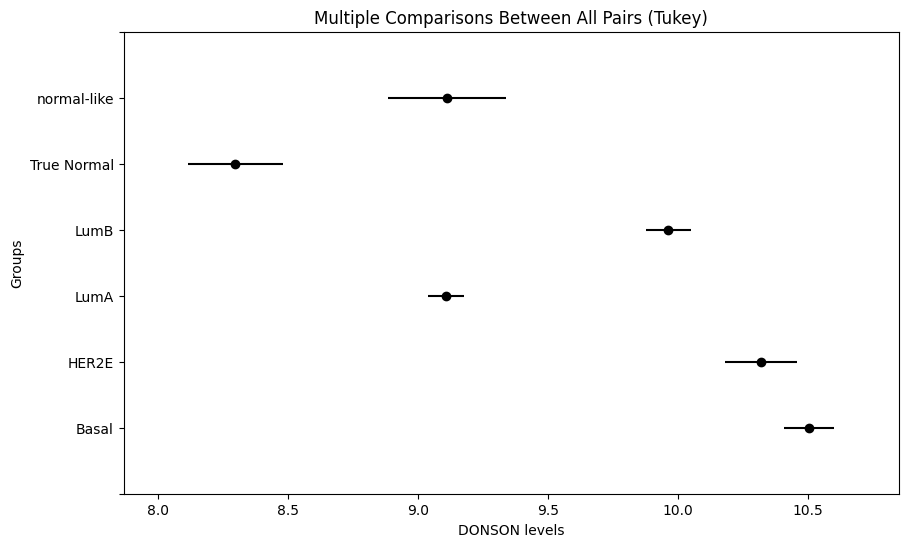

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))
tukey_test.plot_simultaneous(xlabel=f"{gene_sym} levels", ylabel="Groups", ax=ax)
plt.show()

Results interpretation: True normal group is significantly different from all other groups where DONSON is upregulated. Almost all groups are significantly diffirent from each other, except for Basal/HER2E and LumA/normal-like.


# Conclusion

We can see that DONSON levels gradually increase form less agressive subtypes of breast cancer to more agressive thus DONSON can be a potential indicator for agressiveness of breast cancer subtype.
